## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.<sup>1</sup> This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.<sup>2</sup>

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [25]:
import glob
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [26]:
# hr_filenames = glob.glob('/data/crisdb/*.npz')
hr_filenames = glob.glob('./datasets/crisdb/*.npz')

In [27]:
len(hr_filenames)

1537

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [28]:
# metadata_filename = '/data/crisdb/metadata.csv'
metadata_filename = './datasets/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)

In [29]:
metadata.head()

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


In [30]:
metadata.tail()

,subject,age,sex
1538,m071b,75-79,Male
1539,m163b,75-79,Male
1540,m154a,75-79,Male
1541,m158a,75-79,Male
1542,m154b,75-79,Male


In [31]:
metadata.describe()

,subject,age,sex
count,1543,1543,1543
unique,1543,11,2
top,e198a,60-64,Male
freq,1,313,1266


In [32]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  1543 non-null   object
 1   age      1543 non-null   object
 2   sex      1543 non-null   object
dtypes: object(3)
memory usage: 36.3+ KB


In [33]:
metadata['age'].value_counts().sort_index(ascending=False)

75-79     98
70-74    196
65-69    291
60-64    313
55-59    261
50-54    164
45-49    124
40-44     62
35-39     28
30-34      4
20-24      2
Name: age, dtype: int64

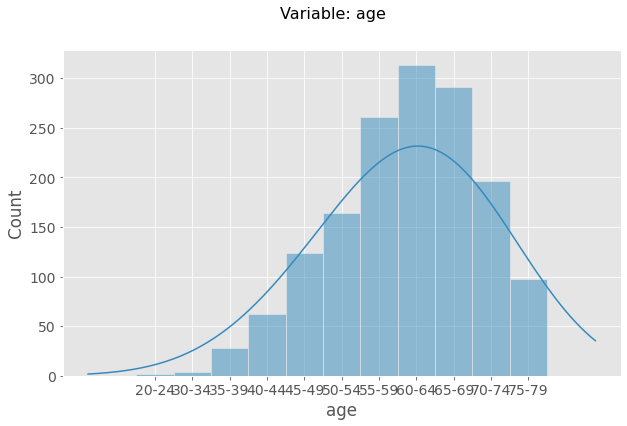

In [34]:
v = 'age'
plt.figure(figsize=(10, 6))
sns.histplot(metadata[v], kde=True, kde_kws={"cut": 1, "bw_adjust": 4});
# sns.countplot(metadata[v], color='r')
plt.suptitle('Variable: {}'.format(v), fontsize=16);

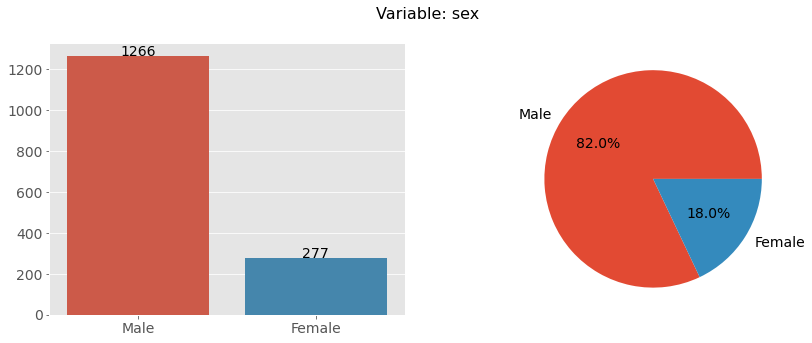

In [35]:
v = 'sex'

# Calculate absolute frequency of each unique value
u_val = metadata[v].unique()
lens = [len(metadata[metadata[v]==val]) for val in u_val]

# Plot style and parameters
plt.style.use("ggplot")
plt.figure(figsize=(14, 5))
plt.suptitle('Variable: {}'.format(v), fontsize=16)
plt.rcParams['font.size'] = 14

# Subplot 1 - Barplot
plt.subplot(121)
ax = sns.barplot(data=metadata, x=u_val, y=metadata[v].value_counts().values)#, hue=u_val)
for i in range(len(u_val)):
    ax.text(i, lens[i], str(lens[i]), fontdict=dict(color='black', fontsize=14),
            horizontalalignment='center')

# Subplot 2 - Pie
plt.subplot(122)
data = list(metadata[v].value_counts())
labels = list(metadata[v].value_counts().index)
plt.pie(data, labels=labels, autopct='%.1f%%');

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [36]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = filename.split("/")[-1].split(".")[0]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata['subject']==subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata['subject']==subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [37]:
df.head()

,age_group,sex,rhr
0,60-64,Male,55.251799
1,55-59,Male,63.198483
2,50-54,Male,54.662614
3,65-69,Male,16.365223
4,50-54,Male,67.368421


In [38]:
df.tail()

,age_group,sex,rhr
1532,55-59,Male,45.240297
1533,65-69,Male,61.196190
1534,65-69,Male,76.408817
1535,65-69,Female,65.362886
1536,60-64,Female,67.964602


In [39]:
df.describe()

,rhr
count,1537.000000
mean,63.547747
std,13.357361
min,1.558870
25%,54.468085
50%,62.439024
75%,71.111111
max,109.714286


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age_group  1537 non-null   object 
 1   sex        1537 non-null   object 
 2   rhr        1537 non-null   float64
dtypes: float64(1), object(2)
memory usage: 36.1+ KB


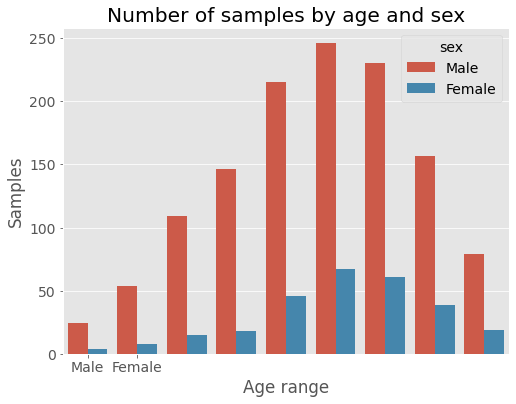

In [41]:
# Get age labels as a list
xlabels = np.sort(df['age_group'].unique()).tolist()

# Add a new column to the dataframe mapping age_group to list index
df['ix_x'] = df['age_group'].map(lambda x: xlabels.index(x))

# Plot number of samples by age and sex
plt.figure(figsize=(8, 6))
sns.countplot(x='ix_x', hue='sex', data=df);
plt.xticks(np.arange(len(labels)), labels);
plt.xlabel('Age range')
plt.ylabel('Samples')
plt.title('Number of samples by age and sex');

In [42]:
# Check
male_35 = len(df[(df["age_group"]=='35-39') & (df["sex"]=='Male')])
female_35 = len(df[(df["age_group"]=='35-39') & (df["sex"]=='Female')])
print('There are {} males and {} females with age 35-39'.format(male_35, female_35))

male_60 = len(df[(df["age_group"]=='60-64') & (df["sex"]=='Male')])
female_60 = len(df[(df["age_group"]=='60-64') & (df["sex"]=='Female')])
print('There are {} males and {} females with age 60-64'.format(male_60, female_60))

There are 24 males and 4 females with age 35-39
There are 246 males and 67 females with age 60-64


In [43]:
# Show number of samples in women by age
df[df['sex']=='Female']['age_group'].value_counts().sort_index(ascending=False)

75-79    19
70-74    39
65-69    61
60-64    67
55-59    46
50-54    18
45-49    15
40-44     8
35-39     4
Name: age_group, dtype: int64

In [44]:
# Show number of samples in men by age
df[df['sex']=='Male']['age_group'].value_counts().sort_index(ascending=False)

75-79     79
70-74    157
65-69    230
60-64    246
55-59    215
50-54    146
45-49    109
40-44     54
35-39     24
Name: age_group, dtype: int64

#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

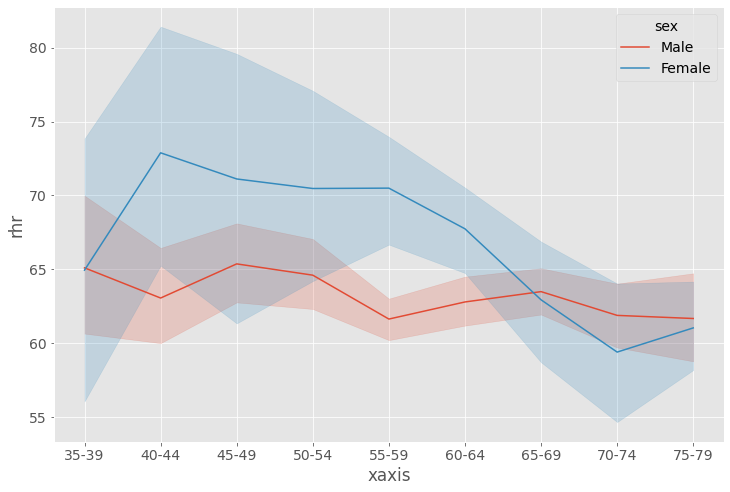

In [45]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see .... 
> 2. For men, we see ... 
> 3. In comparison to men, women's heart rate is .... 
> 4. What are some possible reasons for what we see in our data?
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

In women we see a wide variability (uncertainty). Such is the fact that the variability includes heart rate values that would be considered quite low even in middle age. This high variability could be explained by the fact of having very few samples. Note that in half of the age ranges we have less than 30 samples, and precisely this lack of samples is more pronounced in the age ranges prior to 55 years.

Despite this variability and lack of data, the trend that can be seen is an increase in heart rate until approximately 40 years of age, then a plateau with a slight decrease until 55 years of age, and then a more pronounced decrease.

In the case of men, taking into account that there are many more samples, only a slight decrease in heart rate can be seen over the years. There are certain ups and downs, but they are not very relevant compared to those of women.

Compared to men, women's heart rate is considerably higher and does not reach the same level (or even lower it) until the age range of 65-69 years.

Some of the possible reasons for what we see are as follows. On the one hand, there may be a series of unknown factors that establish a bias; for example, the level of stress, the practice of sports, healthy habits, caffeine intake, etc. On the other hand, given the difference between the number of samples between men and women, it is clear that the bias already exists here.

In my opinion, the first way to improve the results would be to obtain many more samples in all age ranges in women, so that the number of samples was balanced with that of men.

I do not think that with these data we have been able to validate the statement about the trend. It seems to be validated in the case of women, but we have so few samples that it is unreliable. In the case of men, which is where we have an apparently sufficient number of samples, the trend is not validated.

In the next figure we see a plot without distinction between men and women. In this cases, due to the influence of women, it seems that the trend is validated. Probably, with a balanced number of samples, we would see this trend better. Anyway, with these data we are left with the question of whether the statement for the entire population is only valid for a subset (women) or is it a general guideline.

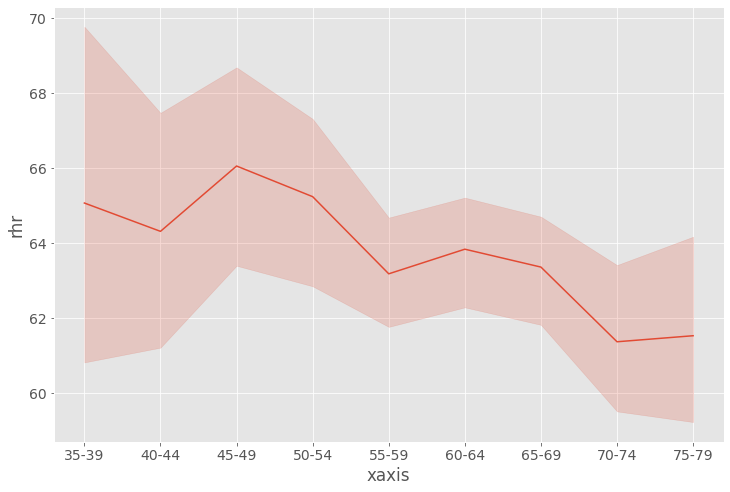

In [46]:
# Plot without distinction between men and women
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)